# Importing libraries and setting the device.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Inspecting the data.

In [24]:
folders = ["test", "train", "valid"]
inner_folders = ["fake", "real"]

total_fake = 0
total_real = 0

for i in range(len(folders)):
  for j in range(len(inner_folders)):
    x = os.listdir(f"/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/{folders[i]}/{inner_folders[j]}")
    print(f"Length of {inner_folders[j]} images in {folders[i]} : {len(x)}")
    if(inner_folders[j] == "real"):
      total_real += len(x)
    else:
      total_fake += len(x)

print(f"Total Number of Real images in dataset: {total_real}")

print(f"Total Number of Fake images in dataset: {total_fake}")

Length of fake images in test : 10000
Length of real images in test : 10000
Length of fake images in train : 50000
Length of real images in train : 50000
Length of fake images in valid : 10000
Length of real images in valid : 10000
Total Number of Real images in dataset: 70000
Total Number of Fake images in dataset: 70000


In [6]:
data_dir = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

# Viewing the first 3 real and fake numbers.

Displaying the first 3 real images:


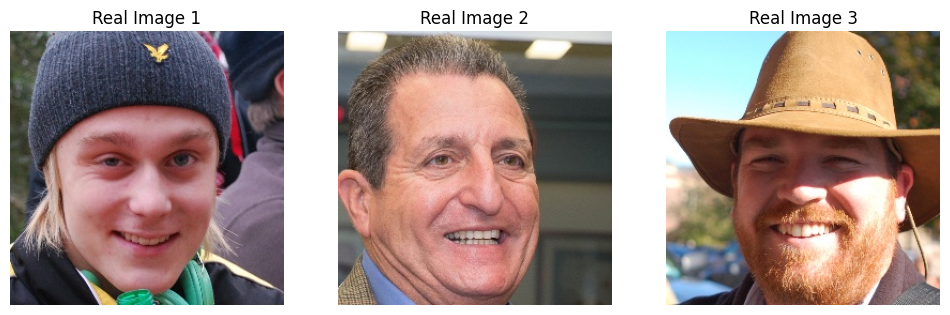

Displaying the first 3 fake images:


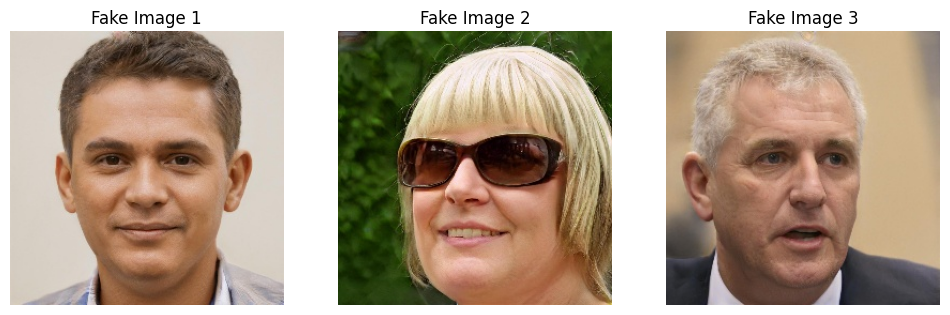

In [9]:
from PIL import Image
def show_first_images(data_dir, class_type, num_images=3):

    folder_path = os.path.join(data_dir, "train", class_type)
    image_files = os.listdir(folder_path)[:num_images]

    plt.figure(figsize=(12, 4))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert("RGB")
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"{class_type.capitalize()} Image {i + 1}")
        plt.axis("off")
    plt.show()

print("Displaying the first 3 real images:")
show_first_images(data_dir, "real")

print("Displaying the first 3 fake images:")
show_first_images(data_dir, "fake")

# **Data Transformation**

Applying the transformation on train, test and validate data.\
Resizing the input images to **64 x 64** for lower computation.

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
data_dirs = {
    'train': os.path.join(data_dir, 'train'),
    'val': os.path.join(data_dir, 'valid'),
    'test': os.path.join(data_dir, 'test')
}

# Dataset Loading

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=data_dirs['train'], transform=data_transforms['train'])
val_dataset = ImageFolder(root=data_dirs['val'], transform=data_transforms['val'])
test_dataset = ImageFolder(root=data_dirs['test'], transform=data_transforms['test'])

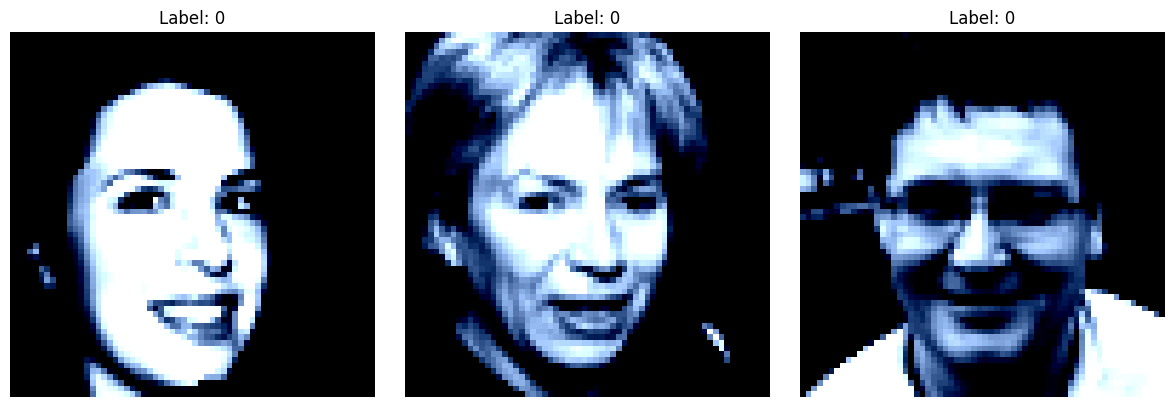

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize the image
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    plt.imshow(img)
    plt.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    image, label = train_dataset[i] 
    axs[i].imshow(image.permute(1, 2, 0).numpy())  # Display the image (transpose the dimensions)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

# 0 => fake // 1 => real

# Data Loading and Combination

This section creates PyTorch `DataLoader` objects to handle efficient data batching and loading for training, validation, and testing.\
Additionally, it combines the training and validation datasets into a single dataset for Kfolds used later in the notebook.

In [10]:
from torch.utils.data import ConcatDataset
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, pin_memory=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=2)
combined_loader = DataLoader(ConcatDataset([train_dataset, val_dataset]),batch_size=200,shuffle=True, pin_memory=True,num_workers=2)
conc_dataset=ConcatDataset([train_dataset, val_dataset])

In [11]:
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}
class_names = train_dataset.classes

print("Dataset Sizes:", dataset_sizes)

print("Class Names:", class_names)

Dataset Sizes: {'train': 100000, 'val': 20000, 'test': 20000}
Class Names: ['fake', 'real']


# Modified VGG16 Model

The SmallVGG model leverages the pre-trained VGG16 architecture for transfer learning, reusing its feature extraction layers to save computational resources and training time.\
The classifier is redesigned to handle binary classification by replacing the original 1,000-class output with a single-node output, tailored for the deepfake detection task.\
Input images are resized to 64×64 to reduce computational load and adapt to dataset constraints, while maintaining enough detail for feature extraction.\
Flattening the feature map output ensures compatibility with the custom fully connected layers, optimizing the model for your specific application.

In [ ]:
import torch.nn as nn

class SmallVGG(nn.Module):
    def __init__(self):
      super(SmallVGG, self).__init__()
      vgg = models.vgg16(weights='IMAGENET1K_V1')
      for param in vgg.parameters():
          param.requires_grad = False
      self.features = vgg.features
      self.classifier = nn.Sequential(
          nn.Linear(512 * 2 * 2, 4096),  # Input size adjusted for 64x64 images
          nn.ReLU(True),
          nn.Dropout(),
          nn.Linear(4096, 4096),
          nn.ReLU(True),
          nn.Dropout(),
          nn.Linear(4096, 1),  # Replace num_classes with your target classes
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Objective function for the models

In [22]:
def objective(trial, model):
    if(model=="vgg16"):
        lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
        model = SmallVGG()
    elif(model=="Alexnet"):
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
        model = SmallAlexNet()
    elif(model=="ResNet18"):
        lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
        model = ResNet18()
    elif(model=="EfficientB0"):
        lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
        model = SmallEfficientNetB0()

    
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    # Use only the classifier parameters for optimization
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    print(f"Trial: {trial.number} with learning rate: {lr}")

    # Training loop
    model.train()
    with tqdm(train_loader, desc=f"Train Trial: {trial.number}", unit="batch", total=len(train_loader)) as tepoch:
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Ensure labels are float and shaped correctly

            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update the progress bar with the loss value
            tepoch.set_postfix(loss=loss.item())

    # Validation loop
    model.eval()
    val_loss = 0.0
    with tqdm(val_loader, desc=f"Validate Trial: {trial.number}", unit="batch", total=len(val_loader)) as tepoch:
        with torch.no_grad():
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)  # Ensure labels are float and shaped correctly
            
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Compute loss during validation
                val_loss += loss.item()  # Accumulate the loss
                
                # Update the progress bar with the loss value
                tepoch.set_postfix(loss=loss.item())
        
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Trial: {trial.number} with validation loss: {avg_val_loss}")
    
    return avg_val_loss  # We aim to minimize the validation loss


# Optuna Optimization algorithm

Using Optuna to try 10 Learning Rates to find the best LR to be used later in the training and validation.

In [38]:
import optuna

# Define a wrapper to pass the model name to the objective function
def objective_wrapper(trial):
    return objective(trial, model="vgg16")

# Create a study object to optimize the objective function
study = optuna.create_study(direction="minimize")

# Optimize using the wrapper function
study.optimize(objective_wrapper, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2024-12-28 20:42:49,733] A new study created in memory with name: no-name-f2821aea-c7c4-4782-9d86-c4b2a65f0625
/tmp/ipykernel_23/2371018967.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)


Using device: cuda
Trial: 0 with learning rate: 0.00031781594029945927


Validate Trial: 0: 100%|██████████| 100/100 [00:34<00:00,  2.92batch/s, loss=0.416]
[I 2024-12-28 20:46:18,030] Trial 0 finished with value: 0.5122915902733802 and parameters: {'lr': 0.00031781594029945927}. Best is trial 0 with value: 0.5122915902733802.


Trial: 0 with validation loss: 0.5122915902733802
Using device: cuda
Trial: 1 with learning rate: 0.02707854650631532


Validate Trial: 1: 100%|██████████| 100/100 [00:26<00:00,  3.73batch/s, loss=0.638]
[I 2024-12-28 20:49:01,065] Trial 1 finished with value: 0.7459393680095673 and parameters: {'lr': 0.02707854650631532}. Best is trial 0 with value: 0.5122915902733802.


Trial: 1 with validation loss: 0.7459393680095673
Using device: cuda
Trial: 2 with learning rate: 0.0030590002094640413


Validate Trial: 2: 100%|██████████| 100/100 [00:26<00:00,  3.74batch/s, loss=0.515]
[I 2024-12-28 20:51:42,424] Trial 2 finished with value: 0.5408477818965912 and parameters: {'lr': 0.0030590002094640413}. Best is trial 0 with value: 0.5122915902733802.


Trial: 2 with validation loss: 0.5408477818965912
Using device: cuda
Trial: 3 with learning rate: 8.948291234170116e-05


Validate Trial: 3: 100%|██████████| 100/100 [00:26<00:00,  3.76batch/s, loss=0.465]
[I 2024-12-28 20:54:23,259] Trial 3 finished with value: 0.5074714297056198 and parameters: {'lr': 8.948291234170116e-05}. Best is trial 3 with value: 0.5074714297056198.


Trial: 3 with validation loss: 0.5074714297056198
Using device: cuda
Trial: 4 with learning rate: 5.8510332041522045e-05


Validate Trial: 4: 100%|██████████| 100/100 [00:26<00:00,  3.75batch/s, loss=0.359]
[I 2024-12-28 20:57:05,688] Trial 4 finished with value: 0.5226247599720955 and parameters: {'lr': 5.8510332041522045e-05}. Best is trial 3 with value: 0.5074714297056198.


Trial: 4 with validation loss: 0.5226247599720955
Using device: cuda
Trial: 5 with learning rate: 0.08669617192396696


Validate Trial: 5: 100%|██████████| 100/100 [00:26<00:00,  3.75batch/s, loss=0.683]
[I 2024-12-28 20:59:47,164] Trial 5 finished with value: 0.678267070055008 and parameters: {'lr': 0.08669617192396696}. Best is trial 3 with value: 0.5074714297056198.


Trial: 5 with validation loss: 0.678267070055008
Using device: cuda
Trial: 6 with learning rate: 0.02260715138847408


Validate Trial: 6: 100%|██████████| 100/100 [00:26<00:00,  3.71batch/s, loss=0.67]
[I 2024-12-28 21:02:29,549] Trial 6 finished with value: 0.715611184835434 and parameters: {'lr': 0.02260715138847408}. Best is trial 3 with value: 0.5074714297056198.


Trial: 6 with validation loss: 0.715611184835434
Using device: cuda
Trial: 7 with learning rate: 4.88150460091321e-05


Validate Trial: 7: 100%|██████████| 100/100 [00:25<00:00,  3.85batch/s, loss=0.453]
[I 2024-12-28 21:05:11,281] Trial 7 finished with value: 0.5170481699705124 and parameters: {'lr': 4.88150460091321e-05}. Best is trial 3 with value: 0.5074714297056198.


Trial: 7 with validation loss: 0.5170481699705124
Using device: cuda
Trial: 8 with learning rate: 0.0010578649122500992


Validate Trial: 8: 100%|██████████| 100/100 [00:26<00:00,  3.72batch/s, loss=0.451]
[I 2024-12-28 21:07:54,270] Trial 8 finished with value: 0.5236404398083687 and parameters: {'lr': 0.0010578649122500992}. Best is trial 3 with value: 0.5074714297056198.


Trial: 8 with validation loss: 0.5236404398083687
Using device: cuda
Trial: 9 with learning rate: 0.02756316201934342


Validate Trial: 9: 100%|██████████| 100/100 [00:26<00:00,  3.71batch/s, loss=0.936]
[I 2024-12-28 21:10:37,192] Trial 9 finished with value: 0.6888252916932106 and parameters: {'lr': 0.02756316201934342}. Best is trial 3 with value: 0.5074714297056198.


Trial: 9 with validation loss: 0.6888252916932106
Best hyperparameters: {'lr': 8.948291234170116e-05}


In [39]:
BestLR = study.best_params
print(BestLR)

{'lr': 8.948291234170116e-05}


# Plotting the Loss and Delta of loss

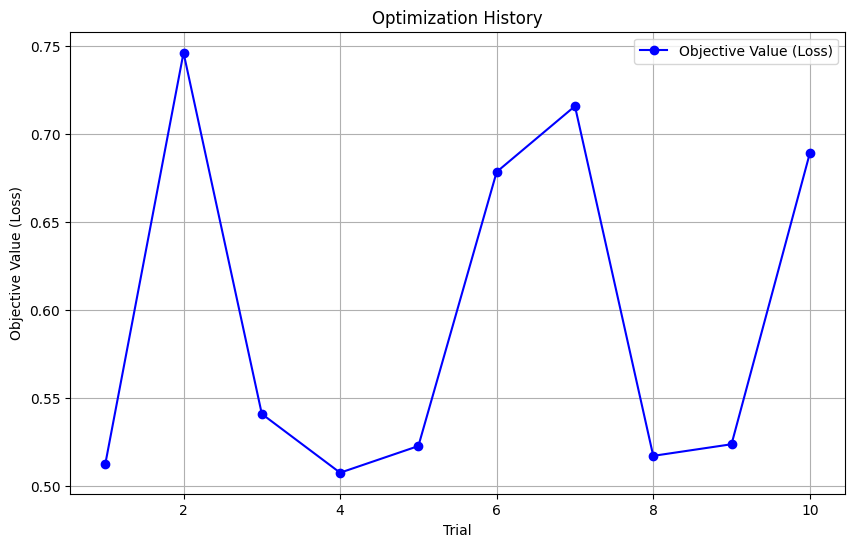

In [40]:
history = [trial.value for trial in study.trials] 


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history) + 1), history, marker='o', color='b', label='Objective Value (Loss)')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.title('Optimization History')
plt.grid(True)
plt.legend()
plt.show()

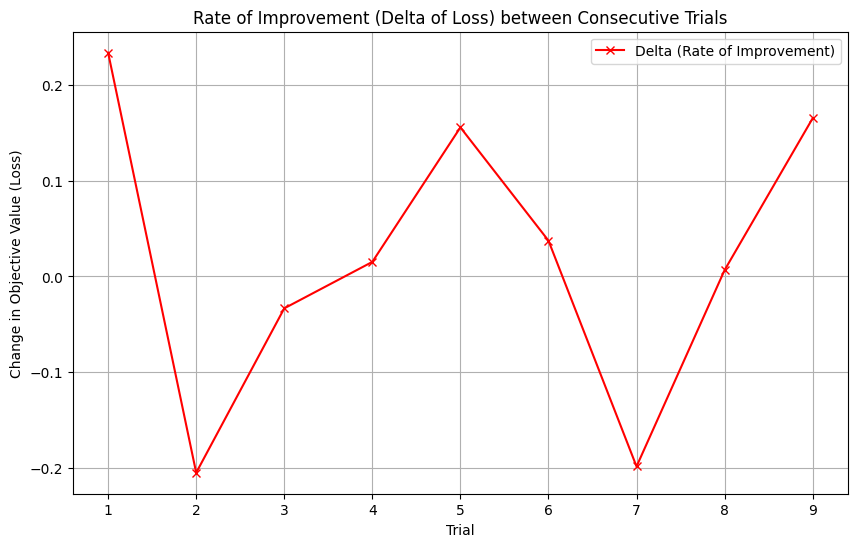

In [41]:
delta_history = np.diff(history)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(delta_history) + 1), delta_history, marker='x', color='r', label='Delta (Rate of Improvement)')
plt.xlabel('Trial')
plt.ylabel('Change in Objective Value (Loss)')
plt.title('Rate of Improvement (Delta of Loss) between Consecutive Trials')
plt.grid(True)
plt.legend()
plt.show()

# Train, evaluate and Test functions.


In [33]:
from torch.utils.data import DataLoader, ConcatDataset, Subset

def train_model(model, combined_dataset, criterion, optimizer, num_epochs=10, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    
    fold_metrics = {
        "train_losses": [],
        "valid_losses": [],
        "train_accuracies": [],
        "valid_accuracies": [],
        "precisions": [],
        "recalls": [],
        "best_accuracy": []
    }

    for fold, (train_idx, valid_idx) in enumerate(kfold.split(combined_dataset)):
        print(f"\nFold {fold+1}/{k}")

        
        train_subset = Subset(combined_dataset, train_idx)
        valid_subset = Subset(combined_dataset, valid_idx)

        train_loader = DataLoader(train_subset, batch_size=200, shuffle=True)
        valid_loader = DataLoader(valid_subset, batch_size=200, shuffle=False)

        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
    
        
        model = model.to(device)
        criterion = criterion.to(device)

        best_val_accuracy = 0.0
        fold_precision = 0
        fold_recall = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            
            with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", total=len(train_loader)) as tepoch:
                for inputs, labels in tepoch:
                    inputs, labels = inputs.to(device), labels.to(device)
                    labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss

                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels) 

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    # Track training statistics
                    running_loss += loss.item()
                    preds = torch.round(torch.sigmoid(outputs))
                    correct += (preds.squeeze() == labels).sum().item()
                    total += labels.size(0)

                    # Update progress bar
                    tepoch.set_postfix(loss=running_loss / (tepoch.n + 1), accuracy=correct / total * 100)

            
            train_accuracy = correct / total * 100
            fold_metrics["train_losses"].append(running_loss / len(train_loader))
            fold_metrics["train_accuracies"].append(train_accuracy)

            print(f"Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%") 

            # Validation loop with tqdm progress bar
            model.eval()
            correct = 0
            total = 0
            running_valid_loss = 0.0
            all_preds = []
            all_labels = []
            with tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch", total=len(valid_loader)) as vepoch:
                with torch.no_grad():
                    for inputs, labels in vepoch:
                        inputs, labels = inputs.to(device), labels.to(device)
                        labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss
                        outputs = model(inputs)
                        loss = criterion(outputs.squeeze(), labels)

                        running_valid_loss += loss.item()

                        preds = torch.round(torch.sigmoid(outputs))
                        correct += (preds.squeeze() == labels).sum().item()
                        total += labels.size(0)

                        all_preds.extend(preds.squeeze().cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())

                        # Update progress bar
                        vepoch.set_postfix(loss=running_valid_loss / (vepoch.n + 1), accuracy=correct / total * 100)

                val_accuracy = correct / total * 100
                fold_metrics["valid_losses"].append(running_valid_loss / len(valid_loader))
                fold_metrics["valid_accuracies"].append(val_accuracy)

            
            precision = precision_score(all_labels, all_preds)
            recall = recall_score(all_labels, all_preds)
            fold_precision += precision
            fold_recall += recall

            print(f"Validation Accuracy: {val_accuracy:.2f}%")
            print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

            # Save the best model based on validation accuracy
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")

        
        fold_metrics["best_accuracy"].append(best_val_accuracy)
        fold_metrics["precisions"].append(fold_precision / num_epochs)
        fold_metrics["recalls"].append(fold_recall / num_epochs)

    
    avg_train_loss = sum(fold_metrics["train_losses"]) / len(fold_metrics["train_losses"])
    avg_valid_loss = sum(fold_metrics["valid_losses"]) / len(fold_metrics["valid_losses"])
    avg_train_accuracy = sum(fold_metrics["train_accuracies"]) / len(fold_metrics["train_accuracies"])
    avg_valid_accuracy = sum(fold_metrics["valid_accuracies"]) / len(fold_metrics["valid_accuracies"])
    avg_precision = sum(fold_metrics["precisions"]) / len(fold_metrics["precisions"])
    avg_recall = sum(fold_metrics["recalls"]) / len(fold_metrics["recalls"])
    avg_best_accuracy = sum(fold_metrics["best_accuracy"]) / len(fold_metrics["best_accuracy"])

    print(f"\nAverage Train Loss: {avg_train_loss:.4f}, Average Train Accuracy: {avg_train_accuracy:.2f}%")
    print(f"Average Validation Loss: {avg_valid_loss:.4f}, Average Validation Accuracy: {avg_valid_accuracy:.2f}%")
    print(f"Average Precision: {avg_precision:.2f}, Average Recall: {avg_recall:.2f}")
    print(f"Average Best Validation Accuracy: {avg_best_accuracy:.2f}%")

    return model, fold_metrics



def test_model(model, test_loader):
    model.eval() 
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch", total=len(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)  
            preds = torch.round(torch.sigmoid(outputs))  # Binary predictions (0 or 1)

            # Adjust for correct dimensions
            all_preds.extend(preds.squeeze(1).cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

            correct += (preds.squeeze(1) == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_preds, all_labels


# Train the model using 3 folds using **Kfold** and **2 epochs**.

In [ ]:
BEST_LR_VGG=study.best_params['lr']

vgg16 = SmallVGG()
vgg16.to(device)

criterion = nn.BCEWithLogitsLoss()  # For binary classification

# optimizer = optim.Adam(vgg16.parameters(),lr=BEST_LR_VGG)
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=BEST_LR_VGG)

mname="vgg"

trained_vgg16,fold_matrix=train_model(vgg16,conc_dataset, criterion, optimizer, num_epochs=2, k=3)

In [72]:
# Testing the model
test_preds_vgg, test_labels_vgg = test_model(trained_vgg16, test_loader)
# Save the model state_dict (recommended approach)
torch.save(trained_vgg16.state_dict(), "vgg16_trained.pth")
print("Model saved successfully as vgg16_trained.pth")

Testing: 100%|██████████| 20000/20000 [01:11<00:00, 278.82batch/s]


Test Accuracy: 78.56%
Model saved successfully as vgg16_trained.pth


In [55]:
import zipfile
import os

# Define the model files you want to zip
model_files = [
    "/kaggle/working/vgg16_trained.pth"
]

# Define the name for the zip file
zip_filename = "/kaggle/working/modelsv2.zip"

# Zip the model files using the zipfile module
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for model_file in model_files:
        zipf.write(model_file, os.path.basename(model_file))  # Add each model file to the zip

print("Model files have been zipped successfully.")


Model files have been zipped successfully.


In [56]:
from IPython.display import FileLink
FileLink(r'modelsv2.zip')


/kaggle/working/modelsv2.zip

In [54]:
import matplotlib.pyplot as plt

def plot_fold_metrics(train_losses,valid_losses,train_accuracies,valid_accuracies,precisions,recalls,best_accuracies):
    fig, ax = plt.subplots(3, 2, figsize=(14, 18))

    # Plot training and validation loss
    ax[0, 0].plot(train_losses, label="Training Loss", color="blue")
    ax[0, 0].plot(valid_losses, label="Validation Loss", color="red")
    ax[0, 0].set_title("Loss over Epochs")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].legend()

    # Plot training and validation accuracy
    ax[0, 1].plot(train_accuracies, label="Training Accuracy", color="blue")
    ax[0, 1].plot(valid_accuracies, label="Validation Accuracy", color="red")
    ax[0, 1].set_title("Accuracy over Epochs")
    ax[0, 1].set_xlabel("Epochs")
    ax[0, 1].set_ylabel("Accuracy (%)")
    ax[0, 1].legend()

    # Plot precision
    ax[1, 0].plot(precisions, label="Precision", color="green", marker="o")
    ax[1, 0].set_title("Precision over Folds")
    ax[1, 0].set_xlabel("Folds")
    ax[1, 0].set_ylabel("Precision")
    ax[1, 0].legend()

    # Plot recall
    ax[1, 1].plot(recalls, label="Recall", color="orange", marker="o")
    ax[1, 1].set_title("Recall over Folds")
    ax[1, 1].set_xlabel("Folds")
    ax[1, 1].set_ylabel("Recall")
    ax[1, 1].legend()

    # Plot best accuracy
    ax[2, 0].plot(best_accuracies, label="Best Accuracy per Fold", color="purple", marker="o")
    ax[2, 0].set_title("Best Validation Accuracy per Fold")
    ax[2, 0].set_xlabel("Folds")
    ax[2, 0].set_ylabel("Accuracy (%)")
    ax[2, 0].legend()

    # Hide unused subplot
    ax[2, 1].axis("off")

    plt.tight_layout()
    plt.show()

{'train_losses': [0.5528948698192835, 0.5040605153143406, 0.4938485862314701, 0.4722949478030205, 0.4645447468012571, 0.44627194449305535], 'valid_losses': [0.5163439390063286, 0.4963057041168213, 0.46755258113145826, 0.45213237062096595, 0.45978913746774197, 0.4187444318830967], 'train_accuracies': [71.54625, 75.2325, 75.94, 77.20125, 77.6775, 78.84625], 'valid_accuracies': [74.395, 75.8425, 77.2325, 78.68, 77.745, 80.7225], 'precisions': [0.7545920950077539, 0.8149726506962516, 0.856725956113509], 'recalls': [0.7508229426433914, 0.7238176523747364, 0.7071435702875399], 'best_accuracy': [75.8425, 78.68, 80.7225]}


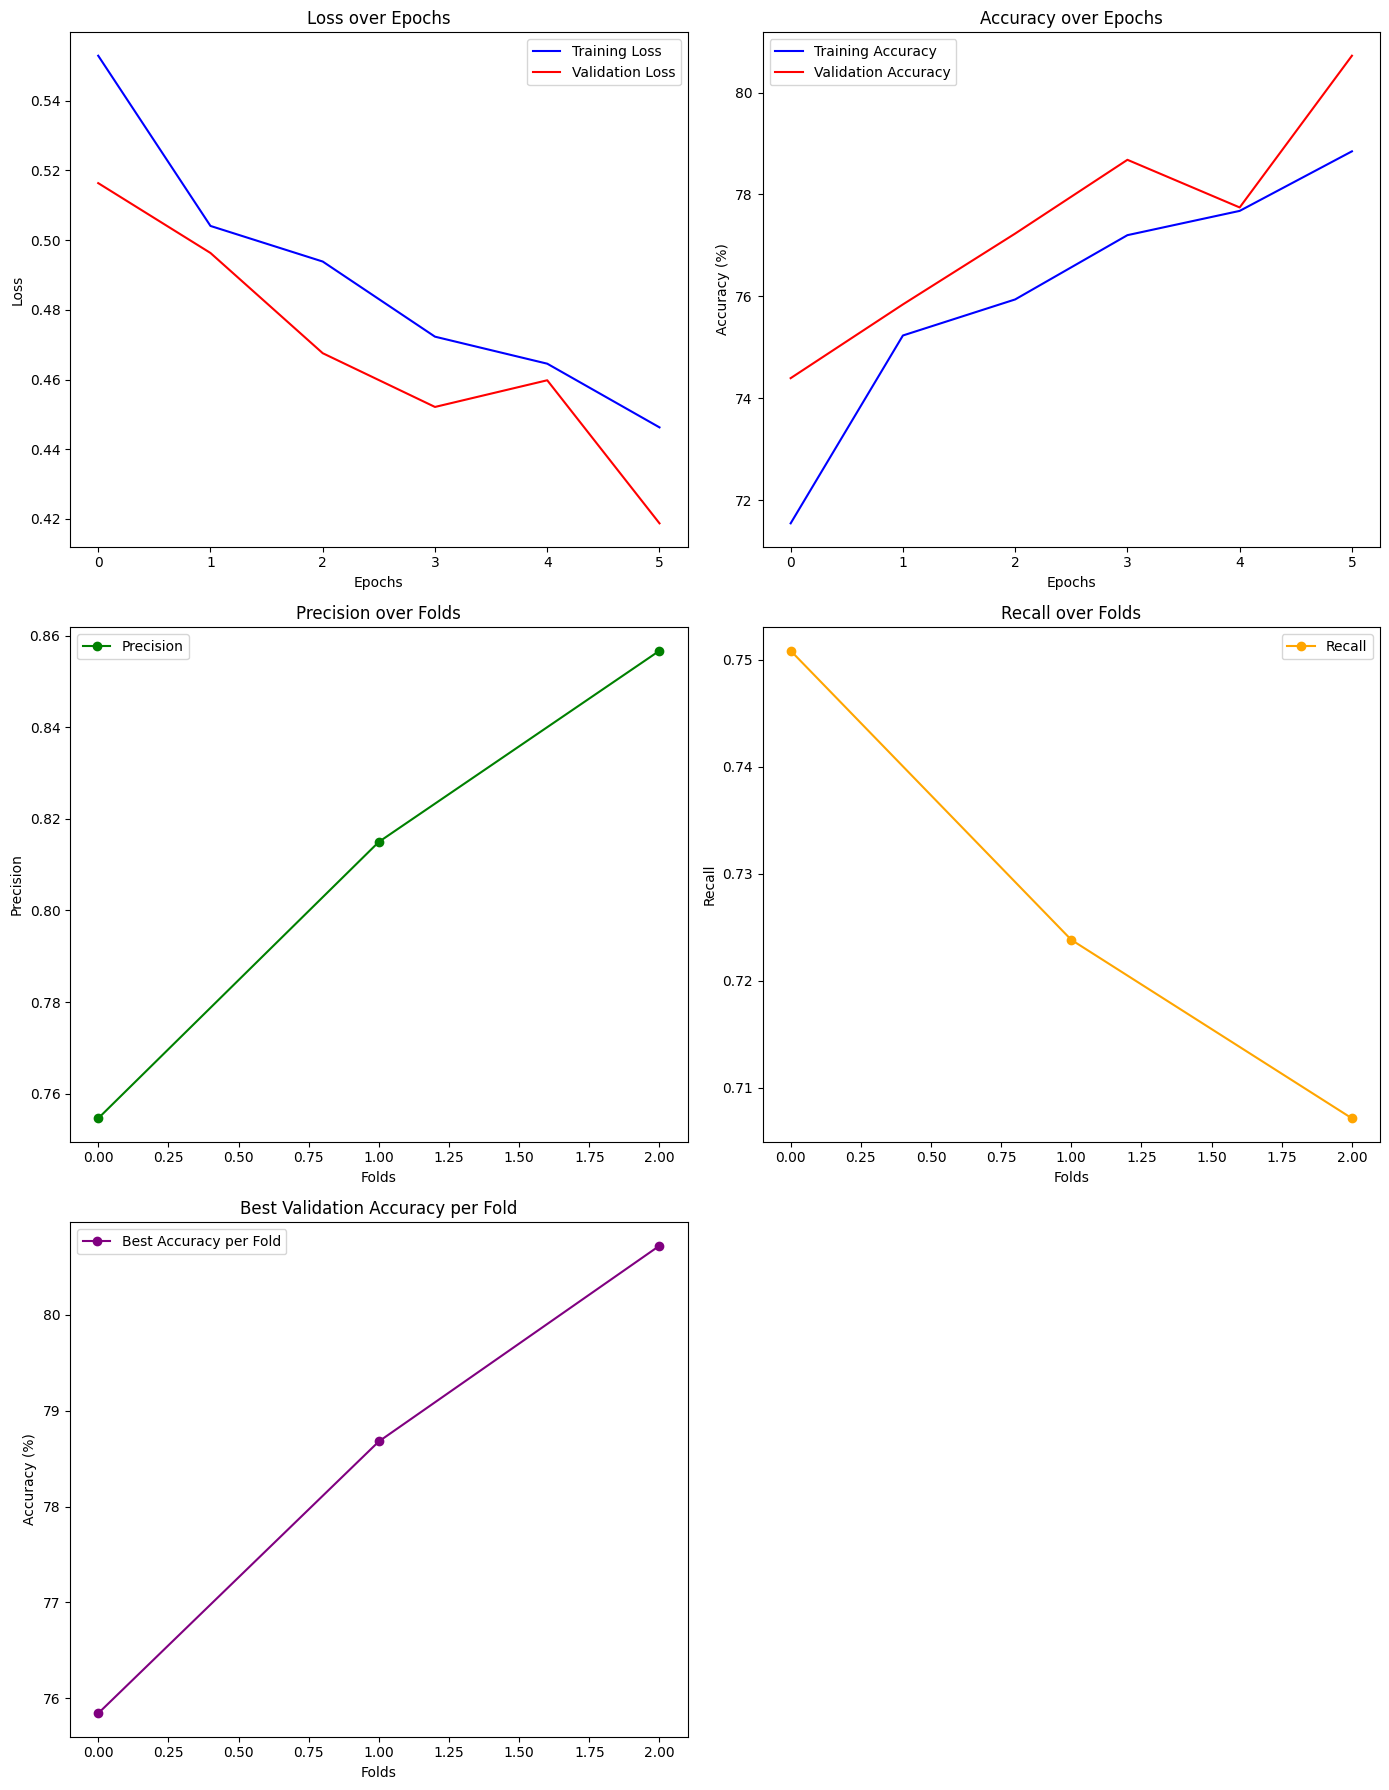

In [73]:
# Assuming fold_matrix is returned from the train_model function for the VGG16
print(fold_matrix)

plot_fold_metrics(
    train_losses=fold_matrix["train_losses"],
    valid_losses=fold_matrix["valid_losses"],
    train_accuracies=fold_matrix["train_accuracies"],
    valid_accuracies=fold_matrix["valid_accuracies"],
    precisions=fold_matrix["precisions"],
    recalls=fold_matrix["recalls"],
    best_accuracies=fold_matrix["best_accuracy"]
)


# Fine Tuning VGG16 model

In [81]:
def layers(model):
    for idx, layer in enumerate(model.features):
        print(f"Layer {idx}: {layer.__class__.__name__}")

    print("\nFully Connected layers:")
    for idx, layer in enumerate(model.classifier):
        print(f"Layer {idx + len(model.features)}: {layer.__class__.__name__}")
layers(vgg16)

Layer 0: Conv2d
Layer 1: ReLU
Layer 2: Conv2d
Layer 3: ReLU
Layer 4: MaxPool2d
Layer 5: Conv2d
Layer 6: ReLU
Layer 7: Conv2d
Layer 8: ReLU
Layer 9: MaxPool2d
Layer 10: Conv2d
Layer 11: ReLU
Layer 12: Conv2d
Layer 13: ReLU
Layer 14: Conv2d
Layer 15: ReLU
Layer 16: MaxPool2d
Layer 17: Conv2d
Layer 18: ReLU
Layer 19: Conv2d
Layer 20: ReLU
Layer 21: Conv2d
Layer 22: ReLU
Layer 23: MaxPool2d
Layer 24: Conv2d
Layer 25: ReLU
Layer 26: Conv2d
Layer 27: ReLU
Layer 28: Conv2d
Layer 29: ReLU
Layer 30: MaxPool2d

Fully Connected layers:
Layer 31: Linear
Layer 32: ReLU
Layer 33: Dropout
Layer 34: Linear
Layer 35: ReLU
Layer 36: Dropout
Layer 37: Linear


In [86]:
def unfreeze_last_layers(model, name):

    # Unfreeze layers based on model type
    if name == "vgg16":
        for param in model.features[26:].parameters():
            param.requires_grad = True

    elif name=="Resnet18":
        for param in model.layer4.parameters():
            param.requires_grad = True

    elif name=="Alexnet":
        for param in model.features[8:].parameters():
            param.requires_grad = True

    return model


In [83]:
vgg16 = unfreeze_last_layers(vgg16, "vgg16")

optimizer = optim.Adam([
    {'params': vgg16.classifier.parameters(), 'lr': BEST_LR_VGG},  # Use the best LR for classifier
    {'params': vgg16.features.parameters(), 'lr': 1e-5}  # Lower LR for the frozen feature extractor layers
])

num_epochs_finetuning = 5

trained_vgg16_finetuned, fold_matrix_finetuning = train_model(
    vgg16, conc_dataset, criterion, optimizer, num_epochs=num_epochs_finetuning, k=2
)



Fold 1/2
Using device: cuda


Epoch 1/5: 100%|██████████| 300/300 [02:52<00:00,  1.74batch/s, accuracy=87.3, loss=0.297]


Train Loss: 0.2970, Train Accuracy: 87.27%


Validation Epoch 1/5: 100%|██████████| 300/300 [02:44<00:00,  1.83batch/s, accuracy=90.7, loss=0.231]


Validation Accuracy: 90.72%
Precision: 0.94, Recall: 0.87


Epoch 2/5: 100%|██████████| 300/300 [02:48<00:00,  1.78batch/s, accuracy=89.7, loss=0.243]


Train Loss: 0.2435, Train Accuracy: 89.67%


Validation Epoch 2/5: 100%|██████████| 300/300 [02:42<00:00,  1.85batch/s, accuracy=90.6, loss=0.227]


Validation Accuracy: 90.64%
Precision: 0.91, Recall: 0.90


Epoch 3/5: 100%|██████████| 300/300 [02:50<00:00,  1.76batch/s, accuracy=91.5, loss=0.205]


Train Loss: 0.2050, Train Accuracy: 91.49%


Validation Epoch 3/5: 100%|██████████| 300/300 [02:43<00:00,  1.83batch/s, accuracy=90.1, loss=0.239]


Validation Accuracy: 90.07%
Precision: 0.94, Recall: 0.86


Epoch 4/5: 100%|██████████| 300/300 [02:48<00:00,  1.78batch/s, accuracy=92.8, loss=0.177]


Train Loss: 0.1775, Train Accuracy: 92.81%


Validation Epoch 4/5: 100%|██████████| 300/300 [02:42<00:00,  1.84batch/s, accuracy=90.3, loss=0.244]


Validation Accuracy: 90.27%
Precision: 0.92, Recall: 0.89


Epoch 5/5: 100%|██████████| 300/300 [02:50<00:00,  1.76batch/s, accuracy=94, loss=0.149]  


Train Loss: 0.1489, Train Accuracy: 94.04%


Validation Epoch 5/5: 100%|██████████| 300/300 [02:42<00:00,  1.85batch/s, accuracy=89.9, loss=0.262]


Validation Accuracy: 89.90%
Precision: 0.91, Recall: 0.89

Fold 2/2
Using device: cuda


Epoch 1/5: 100%|██████████| 300/300 [02:49<00:00,  1.77batch/s, accuracy=88.7, loss=0.27] 


Train Loss: 0.2696, Train Accuracy: 88.73%


Validation Epoch 1/5: 100%|██████████| 300/300 [02:42<00:00,  1.84batch/s, accuracy=95.7, loss=0.137]


Validation Accuracy: 95.73%
Precision: 0.98, Recall: 0.94


Epoch 2/5: 100%|██████████| 300/300 [02:57<00:00,  1.69batch/s, accuracy=91.4, loss=0.205]


Train Loss: 0.2050, Train Accuracy: 91.41%


Validation Epoch 2/5: 100%|██████████| 300/300 [02:46<00:00,  1.80batch/s, accuracy=95.3, loss=0.139]


Validation Accuracy: 95.31%
Precision: 0.96, Recall: 0.95


Epoch 3/5: 100%|██████████| 300/300 [02:51<00:00,  1.75batch/s, accuracy=93.3, loss=0.167]


Train Loss: 0.1669, Train Accuracy: 93.32%


Validation Epoch 3/5: 100%|██████████| 300/300 [02:42<00:00,  1.85batch/s, accuracy=94.8, loss=0.131]


Validation Accuracy: 94.81%
Precision: 0.97, Recall: 0.93


Epoch 4/5: 100%|██████████| 300/300 [02:51<00:00,  1.74batch/s, accuracy=94.4, loss=0.141]


Train Loss: 0.1410, Train Accuracy: 94.36%


Validation Epoch 4/5: 100%|██████████| 300/300 [02:44<00:00,  1.83batch/s, accuracy=94.6, loss=0.136]


Validation Accuracy: 94.58%
Precision: 0.94, Recall: 0.95


Epoch 5/5: 100%|██████████| 300/300 [02:49<00:00,  1.77batch/s, accuracy=95.5, loss=0.115]


Train Loss: 0.1146, Train Accuracy: 95.47%


Validation Epoch 5/5: 100%|██████████| 300/300 [02:43<00:00,  1.83batch/s, accuracy=94.7, loss=0.136]

Validation Accuracy: 94.66%
Precision: 0.95, Recall: 0.95

Average Train Loss: 0.1969, Average Train Accuracy: 91.86%
Average Validation Loss: 0.1883, Average Validation Accuracy: 92.67%
Average Precision: 0.94, Average Recall: 0.91
Average Best Validation Accuracy: 93.22%


In [84]:

test_preds_vgg_finetuned, test_labels_vgg_finetuned = test_model(trained_vgg16_finetuned, test_loader)

torch.save(trained_vgg16_finetuned.state_dict(), "vgg16_finetuned.pth")
print("Model fine-tuned and saved successfully as vgg16_finetuned.pth")


Testing: 100%|██████████| 20000/20000 [01:13<00:00, 271.60batch/s]


Test Accuracy: 84.34%
Model fine-tuned and saved successfully as vgg16_finetuned.pth


# Modified AlexNet

The SmallAlexNet model leverages the pre-trained AlexNet architecture for transfer learning, reusing its feature extraction layers to save computational resources and training time. \
The classifier is redesigned to handle binary classification by replacing the original 1,000-class output with a single-node output, tailored for the deepfake detection task \.
Input images are resized to 64×64 to reduce computational load and adapt to dataset constraints, while maintaining enough detail for feature extractio \n.
Flattening the feature map output ensures compatibility with the custom fully connected layers, optimizing the model for your specific application.

In [74]:
import torch
import torch.nn as nn
from torchvision import models

class SmallAlexNet(nn.Module):
    def __init__(self):
        super(SmallAlexNet, self).__init__()
        alexnet = models.alexnet(weights='IMAGENET1K_V1')
        self.features = alexnet.features
        
        for param in self.features.parameters():
            param.requires_grad = False

        # Use a fixed input size for 64x64 images (calculated manually or using a forward pass).
        self.classifier = nn.Sequential(
            nn.Linear(256, 4096),  # Adjusted for AlexNet features and 64x64 input size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1)  # Output for binary classification
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten dynamically
        x = self.classifier(x)
        return x

# Objective for Small AlexNet

In [64]:
import optuna

# Define a wrapper to pass the model name to the objective function
def objective_wrapper(trial):
    return objective(trial, model="Alexnet")

# Create a study object to optimize the objective function
study = optuna.create_study(direction="minimize")

# Optimize using the wrapper function
study.optimize(objective_wrapper, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2024-12-28 23:06:30,197] A new study created in memory with name: no-name-1def06ea-9134-462c-8058-714921f1bcb0
/tmp/ipykernel_23/2553622849.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


Using device: cuda
Trial: 0 with learning rate: 0.0003141439989434172


Validate Trial: 0: 100%|██████████| 100/100 [00:38<00:00,  2.60batch/s, loss=0.586]
[I 2024-12-28 23:09:59,373] Trial 0 finished with value: 0.5823032861948013 and parameters: {'lr': 0.0003141439989434172}. Best is trial 0 with value: 0.5823032861948013.


Trial: 0 with validation loss: 0.5823032861948013
Using device: cuda
Trial: 1 with learning rate: 0.0001994863287694013


Validate Trial: 1: 100%|██████████| 100/100 [00:25<00:00,  3.90batch/s, loss=0.699]
[I 2024-12-28 23:12:34,888] Trial 1 finished with value: 0.5935778006911278 and parameters: {'lr': 0.0001994863287694013}. Best is trial 0 with value: 0.5823032861948013.


Trial: 1 with validation loss: 0.5935778006911278
Using device: cuda
Trial: 2 with learning rate: 0.0013645199143826098


Validate Trial: 2: 100%|██████████| 100/100 [00:24<00:00,  4.07batch/s, loss=0.638]
[I 2024-12-28 23:15:07,721] Trial 2 finished with value: 0.5906793195009231 and parameters: {'lr': 0.0013645199143826098}. Best is trial 0 with value: 0.5823032861948013.


Trial: 2 with validation loss: 0.5906793195009231
Using device: cuda
Trial: 3 with learning rate: 0.00014278365567888313


Validate Trial: 3: 100%|██████████| 100/100 [00:25<00:00,  3.99batch/s, loss=0.613]
[I 2024-12-28 23:17:41,136] Trial 3 finished with value: 0.5903712373971939 and parameters: {'lr': 0.00014278365567888313}. Best is trial 0 with value: 0.5823032861948013.


Trial: 3 with validation loss: 0.5903712373971939
Using device: cuda
Trial: 4 with learning rate: 0.0010724515150266607


Validate Trial: 4: 100%|██████████| 100/100 [00:24<00:00,  4.00batch/s, loss=0.666]
[I 2024-12-28 23:20:13,207] Trial 4 finished with value: 0.5921724677085877 and parameters: {'lr': 0.0010724515150266607}. Best is trial 0 with value: 0.5823032861948013.


Trial: 4 with validation loss: 0.5921724677085877
Using device: cuda
Trial: 5 with learning rate: 0.00024526331154285544


Validate Trial: 5: 100%|██████████| 100/100 [00:25<00:00,  3.96batch/s, loss=0.58]
[I 2024-12-28 23:22:45,887] Trial 5 finished with value: 0.5824466621875763 and parameters: {'lr': 0.00024526331154285544}. Best is trial 0 with value: 0.5823032861948013.


Trial: 5 with validation loss: 0.5824466621875763
Using device: cuda
Trial: 6 with learning rate: 0.003785993059012996


Validate Trial: 6: 100%|██████████| 100/100 [00:24<00:00,  4.09batch/s, loss=0.661]
[I 2024-12-28 23:25:17,357] Trial 6 finished with value: 0.6261609065532684 and parameters: {'lr': 0.003785993059012996}. Best is trial 0 with value: 0.5823032861948013.


Trial: 6 with validation loss: 0.6261609065532684
Using device: cuda
Trial: 7 with learning rate: 0.00035149879657010854


Validate Trial: 7: 100%|██████████| 100/100 [00:25<00:00,  4.00batch/s, loss=0.629]
[I 2024-12-28 23:27:50,225] Trial 7 finished with value: 0.586078269481659 and parameters: {'lr': 0.00035149879657010854}. Best is trial 0 with value: 0.5823032861948013.


Trial: 7 with validation loss: 0.586078269481659
Using device: cuda
Trial: 8 with learning rate: 0.004248383098523097


Validate Trial: 8: 100%|██████████| 100/100 [00:25<00:00,  3.99batch/s, loss=0.614]
[I 2024-12-28 23:30:21,628] Trial 8 finished with value: 0.6313197898864746 and parameters: {'lr': 0.004248383098523097}. Best is trial 0 with value: 0.5823032861948013.


Trial: 8 with validation loss: 0.6313197898864746
Using device: cuda
Trial: 9 with learning rate: 0.0012095760569090978


Validate Trial: 9: 100%|██████████| 100/100 [00:24<00:00,  4.04batch/s, loss=0.56]
[I 2024-12-28 23:32:53,194] Trial 9 finished with value: 0.589605068564415 and parameters: {'lr': 0.0012095760569090978}. Best is trial 0 with value: 0.5823032861948013.


Trial: 9 with validation loss: 0.589605068564415
Best hyperparameters: {'lr': 0.0003141439989434172}


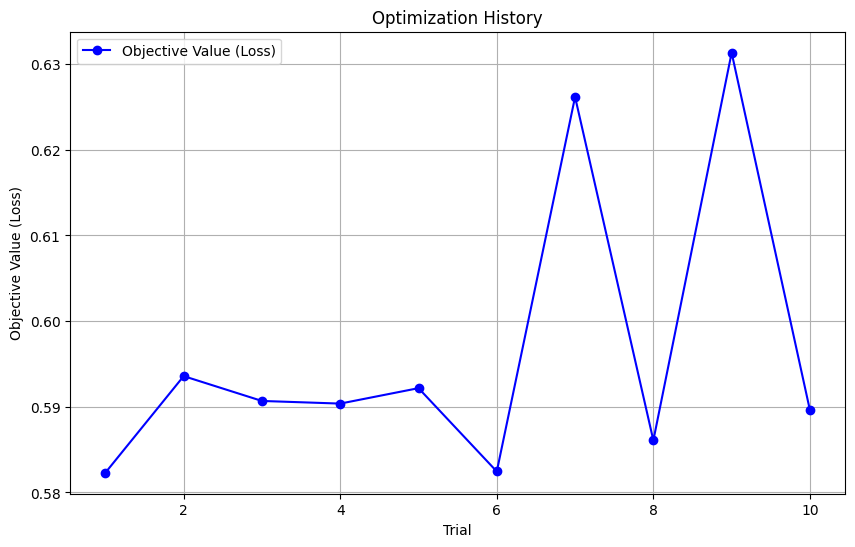

In [65]:
history = [trial.value for trial in study.trials]  # List of objective values (loss in your case)

# Plot the optimization history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history) + 1), history, marker='o', color='b', label='Objective Value (Loss)')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.title('Optimization History')
plt.grid(True)
plt.legend()
plt.show()

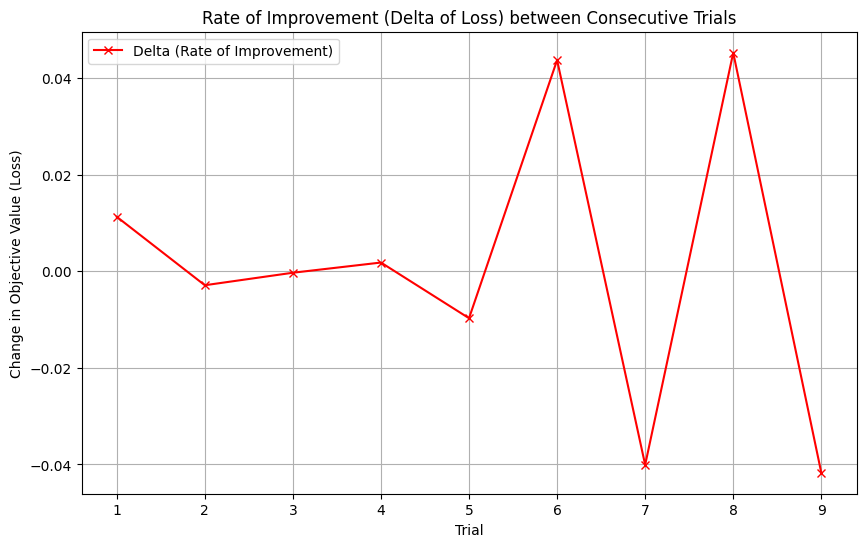

In [66]:
# Calculate the delta between consecutive trials
delta_history = np.diff(history)

# Plotting the rate of improvement (delta of objective values)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(delta_history) + 1), delta_history, marker='x', color='r', label='Delta (Rate of Improvement)')
plt.xlabel('Trial')
plt.ylabel('Change in Objective Value (Loss)')
plt.title('Rate of Improvement (Delta of Loss) between Consecutive Trials')
plt.grid(True)
plt.legend()
plt.show()

In [67]:
BEST_LR_AlexNet=study.best_params['lr']
alex_net = SmallAlexNet()
alex_net.to(device)

criterion = nn.BCEWithLogitsLoss()  # For binary classification

optimizer = optim.Adam(alex_net.classifier.parameters(),lr=BEST_LR_AlexNet)

mname="alex net"

trained_alex,fold_metrics=train_model(alex_net,conc_dataset, criterion, optimizer, num_epochs=2, k=3)


Fold 1/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:13<00:00,  2.07batch/s, accuracy=65.8, loss=0.63] 


Train Loss: 0.6297, Train Accuracy: 65.77%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:34<00:00,  2.12batch/s, accuracy=67, loss=0.601]  


Validation Accuracy: 67.01%
Precision: 0.63, Recall: 0.83


Epoch 2/2: 100%|██████████| 400/400 [03:12<00:00,  2.08batch/s, accuracy=69.1, loss=0.583]


Train Loss: 0.5828, Train Accuracy: 69.08%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:34<00:00,  2.12batch/s, accuracy=69.2, loss=0.581]


Validation Accuracy: 69.18%
Precision: 0.75, Recall: 0.57

Fold 2/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:12<00:00,  2.08batch/s, accuracy=69.7, loss=0.576]


Train Loss: 0.5759, Train Accuracy: 69.67%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:33<00:00,  2.14batch/s, accuracy=71.9, loss=0.55] 


Validation Accuracy: 71.88%
Precision: 0.70, Recall: 0.77


Epoch 2/2: 100%|██████████| 400/400 [03:13<00:00,  2.07batch/s, accuracy=70.6, loss=0.563]


Train Loss: 0.5631, Train Accuracy: 70.59%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:34<00:00,  2.12batch/s, accuracy=70.6, loss=0.563]


Validation Accuracy: 70.61%
Precision: 0.78, Recall: 0.57

Fold 3/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:11<00:00,  2.09batch/s, accuracy=71.3, loss=0.555]


Train Loss: 0.5552, Train Accuracy: 71.33%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:35<00:00,  2.10batch/s, accuracy=72.9, loss=0.534]


Validation Accuracy: 72.93%
Precision: 0.74, Recall: 0.70


Epoch 2/2: 100%|██████████| 400/400 [03:12<00:00,  2.08batch/s, accuracy=72.1, loss=0.544]


Train Loss: 0.5437, Train Accuracy: 72.10%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:34<00:00,  2.13batch/s, accuracy=72.6, loss=0.539]

Validation Accuracy: 72.59%
Precision: 0.70, Recall: 0.79

Average Train Loss: 0.5751, Average Train Accuracy: 69.76%
Average Validation Loss: 0.5614, Average Validation Accuracy: 70.70%
Average Precision: 0.72, Average Recall: 0.70
Average Best Validation Accuracy: 71.33%


In [68]:
# Testing the model
test_preds_alex, test_labels_alex = test_model(trained_alex, test_loader)
# Save the model state_dict (recommended approach)
torch.save(trained_alex.state_dict(), "AlexNet_trained.pth")
print("Model saved successfully as AlexNet_trained.pth")

Testing: 100%|██████████| 20000/20000 [00:57<00:00, 345.25batch/s]


Test Accuracy: 71.57%
Model saved successfully as AlexNet_trained.pth


In [69]:
import zipfile
import os

# Define the model files you want to zip
model_files = [
    "/kaggle/working/AlexNet_trained.pth"
]

# Define the name for the zip file
zip_filename = "/kaggle/working/modelsv2Alex.zip"

# Zip the model files using the zipfile module
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for model_file in model_files:
        zipf.write(model_file, os.path.basename(model_file))  # Add each model file to the zip

print("Model files have been zipped successfully.")


Model files have been zipped successfully.


In [70]:
from IPython.display import FileLink
FileLink(r'modelsv2Alex.zip')


/kaggle/working/modelsv2Alex.zip

{'train_losses': [0.6296549907326698, 0.5827740883827209, 0.5759254905581475, 0.5631007044762373, 0.5552342977374792, 0.5437101302295924], 'valid_losses': [0.6012833596765995, 0.5808861105144024, 0.5495805060863495, 0.5632642732560634, 0.5339628520607949, 0.5392331047356129], 'train_accuracies': [65.77, 69.08375, 69.67, 70.59125, 71.3275, 72.09875], 'valid_accuracies': [67.01, 69.1825, 71.88, 70.6075, 72.9275, 72.59], 'precisions': [0.6920672800838841, 0.7409764037296929, 0.7214616906035003], 'recalls': [0.6989027431421446, 0.6662064464303645, 0.7468051118210863], 'best_accuracy': [69.1825, 71.88, 72.9275]}


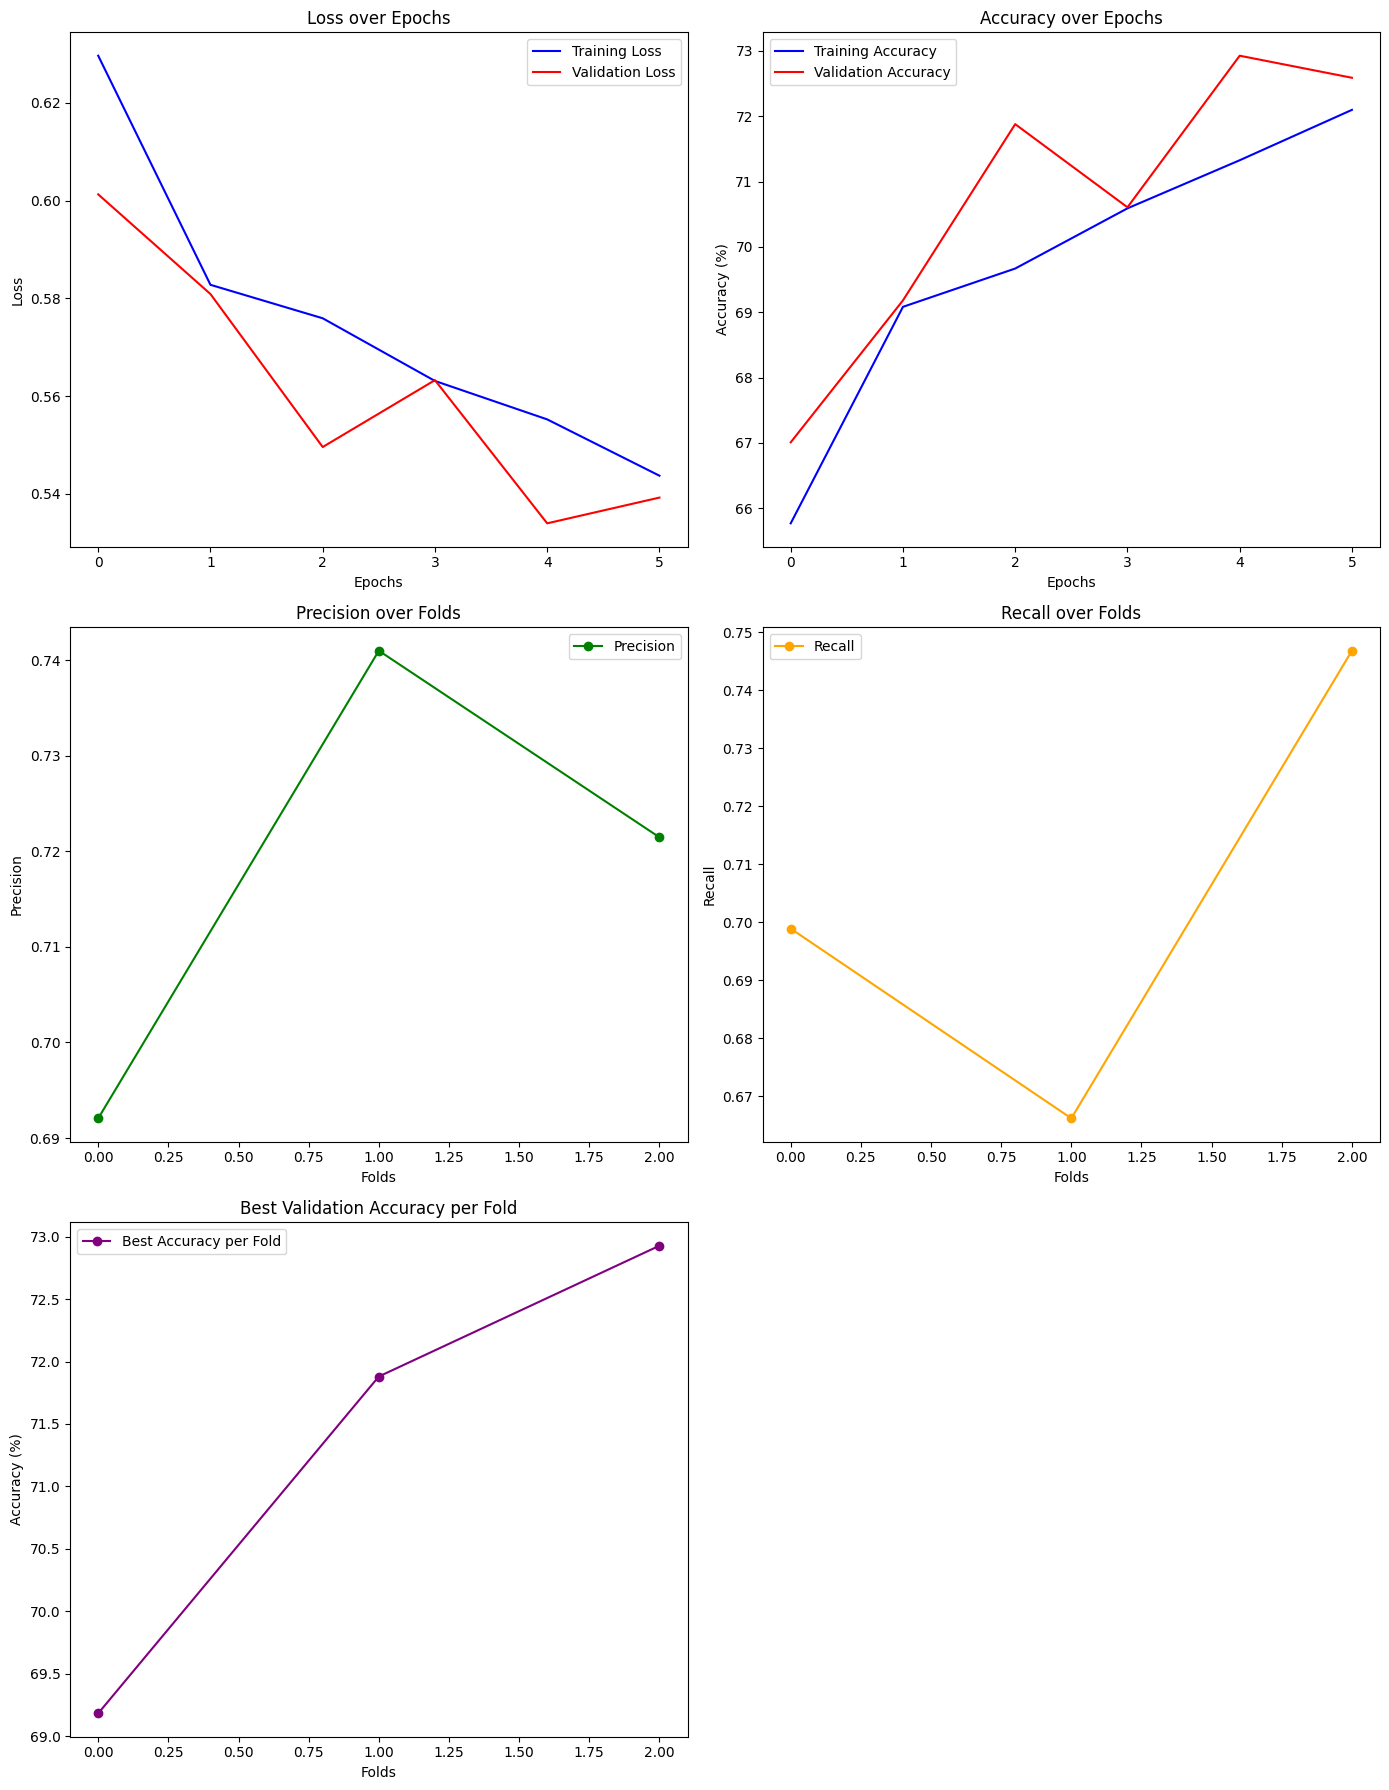

In [80]:
print(fold_metrics)

plot_fold_metrics(
    train_losses=fold_metrics["train_losses"],
    valid_losses=fold_metrics["valid_losses"],
    train_accuracies=fold_metrics["train_accuracies"],
    valid_accuracies=fold_metrics["valid_accuracies"],
    precisions=fold_metrics["precisions"],
    recalls=fold_metrics["recalls"],
    best_accuracies=fold_metrics["best_accuracy"]
)

# Fine tuning AlexNet

In [85]:
layers(alex_net)

Layer 0: Conv2d
Layer 1: ReLU
Layer 2: MaxPool2d
Layer 3: Conv2d
Layer 4: ReLU
Layer 5: MaxPool2d
Layer 6: Conv2d
Layer 7: ReLU
Layer 8: Conv2d
Layer 9: ReLU
Layer 10: Conv2d
Layer 11: ReLU
Layer 12: MaxPool2d

Fully Connected layers:
Layer 13: Linear
Layer 14: ReLU
Layer 15: Dropout
Layer 16: Linear
Layer 17: ReLU
Layer 18: Dropout
Layer 19: Linear


In [88]:
alex_net = unfreeze_last_layers(alex_net, "Alexnet")

optimizer = optim.Adam([
    {'params': alex_net.classifier.parameters(), 'lr': BEST_LR_AlexNet},  # Use the best LR for classifier
    {'params': alex_net.features.parameters(), 'lr': 1e-5}  # Lower LR for the frozen feature extractor layers
])

num_epochs_finetuning = 5

trained_alexnet_finetuned, fold_matrix_finetuning = train_model(
    alex_net, conc_dataset, criterion, optimizer, num_epochs=num_epochs_finetuning, k=2
)



Fold 1/2
Using device: cuda


Epoch 1/5: 100%|██████████| 300/300 [02:26<00:00,  2.04batch/s, accuracy=72.6, loss=0.54] 


Train Loss: 0.5399, Train Accuracy: 72.58%


Validation Epoch 1/5: 100%|██████████| 300/300 [02:25<00:00,  2.06batch/s, accuracy=74.6, loss=0.515]


Validation Accuracy: 74.57%
Precision: 0.74, Recall: 0.76


Epoch 2/5: 100%|██████████| 300/300 [02:25<00:00,  2.06batch/s, accuracy=74.7, loss=0.51] 


Train Loss: 0.5105, Train Accuracy: 74.74%


Validation Epoch 2/5: 100%|██████████| 300/300 [02:24<00:00,  2.08batch/s, accuracy=74.9, loss=0.504]


Validation Accuracy: 74.91%
Precision: 0.73, Recall: 0.80


Epoch 3/5: 100%|██████████| 300/300 [02:26<00:00,  2.05batch/s, accuracy=76.5, loss=0.486]


Train Loss: 0.4857, Train Accuracy: 76.46%


Validation Epoch 3/5: 100%|██████████| 300/300 [02:21<00:00,  2.12batch/s, accuracy=75.4, loss=0.497]


Validation Accuracy: 75.41%
Precision: 0.75, Recall: 0.76


Epoch 4/5: 100%|██████████| 300/300 [02:25<00:00,  2.06batch/s, accuracy=78, loss=0.461]  


Train Loss: 0.4614, Train Accuracy: 77.96%


Validation Epoch 4/5: 100%|██████████| 300/300 [02:23<00:00,  2.10batch/s, accuracy=76.3, loss=0.488]


Validation Accuracy: 76.31%
Precision: 0.76, Recall: 0.76


Epoch 5/5: 100%|██████████| 300/300 [02:25<00:00,  2.06batch/s, accuracy=79.6, loss=0.434]


Train Loss: 0.4335, Train Accuracy: 79.58%


Validation Epoch 5/5: 100%|██████████| 300/300 [02:22<00:00,  2.10batch/s, accuracy=75.9, loss=0.492]


Validation Accuracy: 75.94%
Precision: 0.74, Recall: 0.81

Fold 2/2
Using device: cuda


Epoch 1/5: 100%|██████████| 300/300 [02:25<00:00,  2.06batch/s, accuracy=75.7, loss=0.501]


Train Loss: 0.5008, Train Accuracy: 75.66%


Validation Epoch 1/5: 100%|██████████| 300/300 [02:19<00:00,  2.14batch/s, accuracy=81.6, loss=0.419]


Validation Accuracy: 81.63%
Precision: 0.81, Recall: 0.82


Epoch 2/5: 100%|██████████| 300/300 [02:26<00:00,  2.05batch/s, accuracy=77.2, loss=0.468]


Train Loss: 0.4682, Train Accuracy: 77.23%


Validation Epoch 2/5: 100%|██████████| 300/300 [02:21<00:00,  2.12batch/s, accuracy=81.6, loss=0.418]


Validation Accuracy: 81.56%
Precision: 0.83, Recall: 0.79


Epoch 3/5: 100%|██████████| 300/300 [02:27<00:00,  2.04batch/s, accuracy=78.8, loss=0.443]


Train Loss: 0.4428, Train Accuracy: 78.83%


Validation Epoch 3/5: 100%|██████████| 300/300 [02:20<00:00,  2.14batch/s, accuracy=81.2, loss=0.411]


Validation Accuracy: 81.24%
Precision: 0.79, Recall: 0.86


Epoch 4/5: 100%|██████████| 300/300 [02:25<00:00,  2.06batch/s, accuracy=80.4, loss=0.418]


Train Loss: 0.4180, Train Accuracy: 80.38%


Validation Epoch 4/5: 100%|██████████| 300/300 [02:20<00:00,  2.14batch/s, accuracy=81.5, loss=0.402]


Validation Accuracy: 81.55%
Precision: 0.80, Recall: 0.84


Epoch 5/5: 100%|██████████| 300/300 [02:29<00:00,  2.01batch/s, accuracy=81.8, loss=0.391]


Train Loss: 0.3908, Train Accuracy: 81.78%


Validation Epoch 5/5: 100%|██████████| 300/300 [02:25<00:00,  2.06batch/s, accuracy=81.2, loss=0.407]

Validation Accuracy: 81.21%
Precision: 0.79, Recall: 0.85

Average Train Loss: 0.4652, Average Train Accuracy: 77.52%
Average Validation Loss: 0.4554, Average Validation Accuracy: 78.43%
Average Precision: 0.77, Average Recall: 0.81
Average Best Validation Accuracy: 78.97%


In [89]:
test_preds_alexnet_finetuned, test_labels_alexnet_finetuned = test_model(trained_alexnet_finetuned, test_loader)

torch.save(trained_alexnet_finetuned.state_dict(), "alexnet_finetuned.pth")
print("Model fine-tuned and saved successfully as alexnet_finetuned.pth")


Testing: 100%|██████████| 20000/20000 [00:57<00:00, 346.58batch/s]


Test Accuracy: 76.58%
Model fine-tuned and saved successfully as alexnet_finetuned.pth


# Modiefied ResNet18

The modified ResNet18 model leverages the pre-trained ResNet18 architecture for transfer learning, reusing its feature extraction layers to save computational resources and training time.\
The classifier is redesigned to handle binary classification by replacing the original 1,000-class output with a single-node output, tailored for the deepfake detection task\.
Input images are resized to 64×64 to reduce computational load and adapt to dataset constraints, while maintaining enough detail for feature extractio\n.
Flattening the feature map output ensures compatibility with the custom fully connected layers, optimizing the model for your specific applicati \
Note: Adjust the first convolutional layer to handle smaller input images (64x64), Original input: 224x224 -> ResNet expects a larger input, so we change the kernel sizeon.

In [100]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()

        resnet18 = models.resnet18(weights='IMAGENET1K_V1')
        
        for param in resnet18.parameters():
            param.requires_grad = False

        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        resnet18.fc = nn.Sequential(
            nn.Linear(resnet18.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

        

        self.features = nn.Sequential(*list(resnet18.children())[:-1])  # Use the feature extractor part
        self.classifier = resnet18.fc  # Use the modified classifier

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Resnet18 Objective function

In [101]:
def objective_wrapper(trial):
    return objective(trial, model="ResNet18")

study = optuna.create_study(direction="minimize")

study.optimize(objective_wrapper, n_trials=10)

print("Best hyperparameters:", study.best_params)


[I 2024-12-29 04:40:55,569] A new study created in memory with name: no-name-f3535a5b-9713-46fe-a9e2-48756b8e0542
/tmp/ipykernel_23/703493034.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)


Using device: cuda
Trial: 0 with learning rate: 7.12575237533188e-05


Validate Trial: 0: 100%|██████████| 100/100 [00:25<00:00,  3.94batch/s, loss=0.633]
[I 2024-12-29 04:43:36,545] Trial 0 finished with value: 0.6534741115570069 and parameters: {'lr': 7.12575237533188e-05}. Best is trial 0 with value: 0.6534741115570069.


Trial: 0 with validation loss: 0.6534741115570069
Using device: cuda
Trial: 1 with learning rate: 0.01400477285004633


Validate Trial: 1: 100%|██████████| 100/100 [00:24<00:00,  4.11batch/s, loss=0.699]
[I 2024-12-29 04:46:07,296] Trial 1 finished with value: 0.6865332806110382 and parameters: {'lr': 0.01400477285004633}. Best is trial 0 with value: 0.6534741115570069.


Trial: 1 with validation loss: 0.6865332806110382
Using device: cuda
Trial: 2 with learning rate: 0.00031932602026927496


Validate Trial: 2: 100%|██████████| 100/100 [00:24<00:00,  4.01batch/s, loss=0.626]
[I 2024-12-29 04:48:40,760] Trial 2 finished with value: 0.651295930147171 and parameters: {'lr': 0.00031932602026927496}. Best is trial 2 with value: 0.651295930147171.


Trial: 2 with validation loss: 0.651295930147171
Using device: cuda
Trial: 3 with learning rate: 0.022380919479669505


Validate Trial: 3: 100%|██████████| 100/100 [00:24<00:00,  4.04batch/s, loss=0.704]
[I 2024-12-29 04:51:11,948] Trial 3 finished with value: 0.6927914875745773 and parameters: {'lr': 0.022380919479669505}. Best is trial 2 with value: 0.651295930147171.


Trial: 3 with validation loss: 0.6927914875745773
Using device: cuda
Trial: 4 with learning rate: 5.503267196053347e-05


Validate Trial: 4: 100%|██████████| 100/100 [00:25<00:00,  3.94batch/s, loss=0.676]
[I 2024-12-29 04:53:45,216] Trial 4 finished with value: 0.6590173554420471 and parameters: {'lr': 5.503267196053347e-05}. Best is trial 2 with value: 0.651295930147171.


Trial: 4 with validation loss: 0.6590173554420471
Using device: cuda
Trial: 5 with learning rate: 0.0023417600667415485


Validate Trial: 5: 100%|██████████| 100/100 [00:24<00:00,  4.07batch/s, loss=0.644]
[I 2024-12-29 04:56:18,467] Trial 5 finished with value: 0.6578344297409058 and parameters: {'lr': 0.0023417600667415485}. Best is trial 2 with value: 0.651295930147171.


Trial: 5 with validation loss: 0.6578344297409058
Using device: cuda
Trial: 6 with learning rate: 1.2266768902322654e-05


Validate Trial: 6: 100%|██████████| 100/100 [00:24<00:00,  4.05batch/s, loss=0.646]
[I 2024-12-29 04:58:50,995] Trial 6 finished with value: 0.6738568997383118 and parameters: {'lr': 1.2266768902322654e-05}. Best is trial 2 with value: 0.651295930147171.


Trial: 6 with validation loss: 0.6738568997383118
Using device: cuda
Trial: 7 with learning rate: 0.00013194448900477222


Validate Trial: 7: 100%|██████████| 100/100 [00:23<00:00,  4.17batch/s, loss=0.694]
[I 2024-12-29 05:01:20,765] Trial 7 finished with value: 0.6544897079467773 and parameters: {'lr': 0.00013194448900477222}. Best is trial 2 with value: 0.651295930147171.


Trial: 7 with validation loss: 0.6544897079467773
Using device: cuda
Trial: 8 with learning rate: 0.056311891668599096


Validate Trial: 8: 100%|██████████| 100/100 [00:25<00:00,  3.95batch/s, loss=0.717]
[I 2024-12-29 05:03:53,112] Trial 8 finished with value: 0.6934581857919693 and parameters: {'lr': 0.056311891668599096}. Best is trial 2 with value: 0.651295930147171.


Trial: 8 with validation loss: 0.6934581857919693
Using device: cuda
Trial: 9 with learning rate: 0.09987755771395426


Validate Trial: 9: 100%|██████████| 100/100 [00:25<00:00,  3.96batch/s, loss=0.667]
[I 2024-12-29 05:06:26,265] Trial 9 finished with value: 0.6937692964076996 and parameters: {'lr': 0.09987755771395426}. Best is trial 2 with value: 0.651295930147171.


Trial: 9 with validation loss: 0.6937692964076996
Best hyperparameters: {'lr': 0.00031932602026927496}


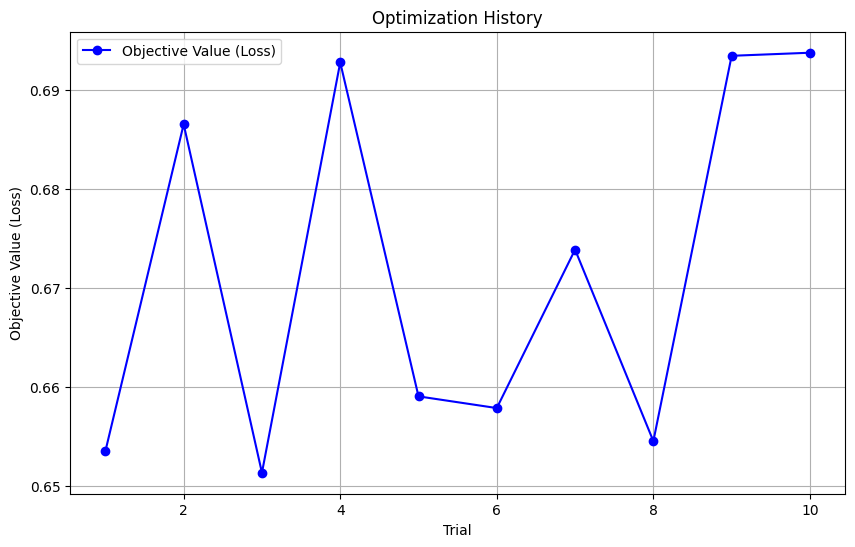

In [102]:
history = [trial.value for trial in study.trials]  # List of objective values (loss in your case)

# Plot the optimization history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history) + 1), history, marker='o', color='b', label='Objective Value (Loss)')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.title('Optimization History')
plt.grid(True)
plt.legend()
plt.show()

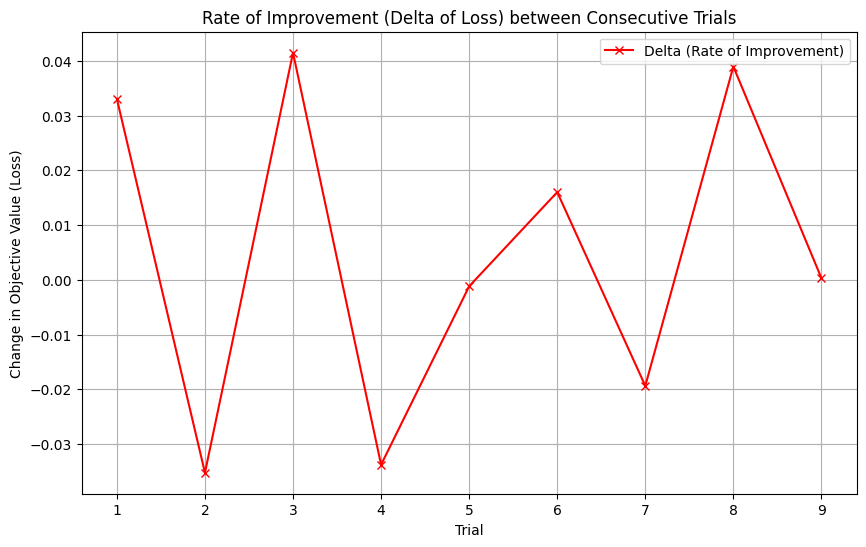

In [103]:
# Calculate the delta between consecutive trials
delta_history = np.diff(history)

# Plotting the rate of improvement (delta of objective values)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(delta_history) + 1), delta_history, marker='x', color='r', label='Delta (Rate of Improvement)')
plt.xlabel('Trial')
plt.ylabel('Change in Objective Value (Loss)')
plt.title('Rate of Improvement (Delta of Loss) between Consecutive Trials')
plt.grid(True)
plt.legend()
plt.show()

In [105]:
BEST_LR_Resnet18=study.best_params['lr']
Resnet18 = ResNet18()
Resnet18.to(device)

criterion = nn.BCEWithLogitsLoss()  # For binary classification

optimizer = optim.Adam(Resnet18.classifier.parameters(),lr=BEST_LR_Resnet18)

trained_Resnet,fold_metrics=train_model(Resnet18,conc_dataset, criterion, optimizer, num_epochs=2, k=3)


Fold 1/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:34<00:00,  1.87batch/s, accuracy=58.4, loss=0.673]


Train Loss: 0.6730, Train Accuracy: 58.42%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:35<00:00,  2.10batch/s, accuracy=60.5, loss=0.661]


Validation Accuracy: 60.50%
Precision: 0.61, Recall: 0.57


Epoch 2/2: 100%|██████████| 400/400 [03:33<00:00,  1.87batch/s, accuracy=61, loss=0.656]  


Train Loss: 0.6564, Train Accuracy: 61.04%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:34<00:00,  2.11batch/s, accuracy=61.4, loss=0.655]


Validation Accuracy: 61.39%
Precision: 0.62, Recall: 0.59

Fold 2/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:36<00:00,  1.85batch/s, accuracy=61.7, loss=0.653]


Train Loss: 0.6529, Train Accuracy: 61.68%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:35<00:00,  2.09batch/s, accuracy=63.4, loss=0.638]


Validation Accuracy: 63.42%
Precision: 0.63, Recall: 0.65


Epoch 2/2: 100%|██████████| 400/400 [03:36<00:00,  1.85batch/s, accuracy=62.4, loss=0.646]


Train Loss: 0.6460, Train Accuracy: 62.44%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:36<00:00,  2.07batch/s, accuracy=63.5, loss=0.638]


Validation Accuracy: 63.51%
Precision: 0.61, Recall: 0.73

Fold 3/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:34<00:00,  1.87batch/s, accuracy=63, loss=0.642]  


Train Loss: 0.6423, Train Accuracy: 62.99%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:36<00:00,  2.07batch/s, accuracy=65.1, loss=0.627]


Validation Accuracy: 65.06%
Precision: 0.66, Recall: 0.64


Epoch 2/2: 100%|██████████| 400/400 [03:35<00:00,  1.86batch/s, accuracy=63.9, loss=0.635]


Train Loss: 0.6346, Train Accuracy: 63.93%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:37<00:00,  2.06batch/s, accuracy=65, loss=0.627]  

Validation Accuracy: 65.04%
Precision: 0.66, Recall: 0.63

Average Train Loss: 0.6509, Average Train Accuracy: 61.75%
Average Validation Loss: 0.6413, Average Validation Accuracy: 63.16%
Average Precision: 0.63, Average Recall: 0.63
Average Best Validation Accuracy: 63.32%


In [106]:
# Testing the model
test_preds_resnet, test_labels_alex = test_model(trained_Resnet, test_loader)
# Save the model state_dict (recommended approach)
torch.save(trained_Resnet.state_dict(), "ResNet18_trained.pth")
print("Model saved successfully as ResNet18_trained.pth")



Testing: 100%|██████████| 20000/20000 [01:34<00:00, 211.74batch/s]

Test Accuracy: 62.66%
Model saved successfully as ResNet18_trained.pth


{'train_losses': [0.6730110114812851, 0.6563594989478588, 0.6529153753817082, 0.6460422636568546, 0.6422975568473339, 0.6346056486666203], 'valid_losses': [0.6612869828939438, 0.6550692269206047, 0.6384941181540489, 0.6384250974655151, 0.6274466502666474, 0.6268389281630516], 'train_accuracies': [58.42125, 61.040000000000006, 61.68, 62.44, 62.99, 63.92875], 'valid_accuracies': [60.4975, 61.392500000000005, 63.425, 63.50749999999999, 65.065, 65.0425], 'precisions': [0.6173817997852293, 0.6201310022067402, 0.6566057699439979], 'recalls': [0.5806234413965088, 0.6895270609498946, 0.6335113817891374], 'best_accuracy': [61.392500000000005, 63.50749999999999, 65.065]}


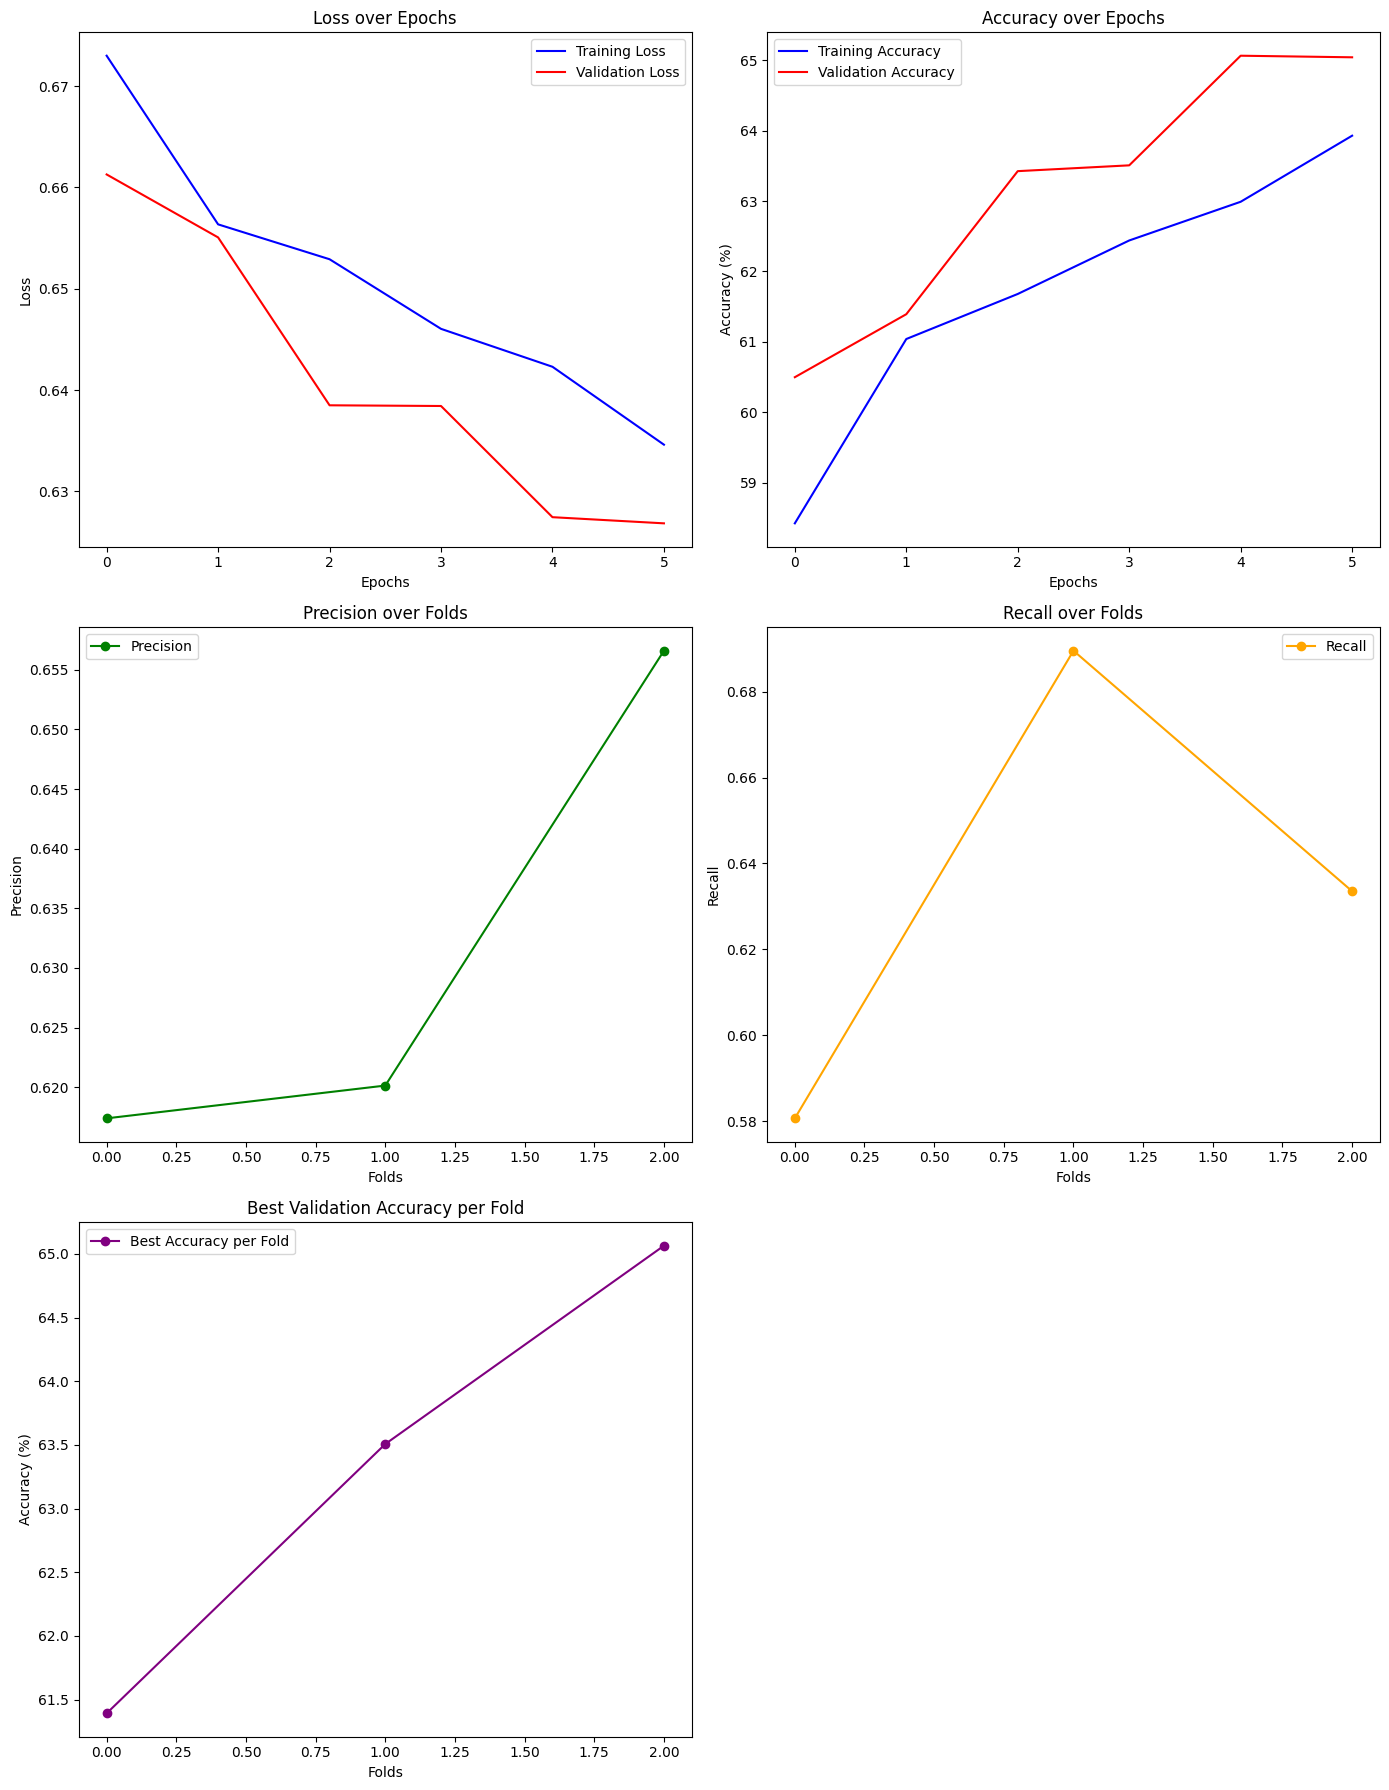

In [107]:
print(fold_metrics)

plot_fold_metrics(
    train_losses=fold_metrics["train_losses"],
    valid_losses=fold_metrics["valid_losses"],
    train_accuracies=fold_metrics["train_accuracies"],
    valid_accuracies=fold_metrics["valid_accuracies"],
    precisions=fold_metrics["precisions"],
    recalls=fold_metrics["recalls"],
    best_accuracies=fold_metrics["best_accuracy"]
)

# Fine Tuning ResNet18

In [108]:
layers(Resnet18)

Layer 0: Conv2d
Layer 1: BatchNorm2d
Layer 2: ReLU
Layer 3: MaxPool2d
Layer 4: Sequential
Layer 5: Sequential
Layer 6: Sequential
Layer 7: Sequential
Layer 8: AdaptiveAvgPool2d

Fully Connected layers:
Layer 9: Linear
Layer 10: ReLU
Layer 11: Dropout
Layer 12: Linear


# Modified EfficientB0

In [26]:
class SmallEfficientNetB0(nn.Module):
    def __init__(self):
        super(SmallEfficientNetB0, self).__init__()
        
        efficientnet_b0 = models.efficientnet_b0(weights='IMAGENET1K_V1')
        
        for param in efficientnet_b0.parameters():
            param.requires_grad = False
        
        self.features = efficientnet_b0.features
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)  # Shape becomes (batch_size, 1280, 1, 1)
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 1280)
        x = self.classifier(x)
        return x


# Objective EfficientNetB0

In [29]:
import optuna

def objective_wrapper(trial):
    return objective(trial, model="EfficientB0")

study = optuna.create_study(direction="minimize")

study.optimize(objective_wrapper, n_trials=3)

print("Best hyperparameters:", study.best_params)

[I 2024-12-29 15:37:49,010] A new study created in memory with name: no-name-a0bf9699-34cd-4969-8fcb-2b9325ae435c
/tmp/ipykernel_23/431158259.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)


Using device: cuda
Trial: 0 with learning rate: 0.0021015200383953875


Validate Trial: 0: 100%|██████████| 100/100 [01:22<00:00,  1.21batch/s, loss=0.669]
[I 2024-12-29 15:46:01,964] Trial 0 finished with value: 0.6191407150030136 and parameters: {'lr': 0.0021015200383953875}. Best is trial 0 with value: 0.6191407150030136.


Trial: 0 with validation loss: 0.6191407150030136
Using device: cuda
Trial: 1 with learning rate: 0.0012959606245359306


Validate Trial: 1: 100%|██████████| 100/100 [00:26<00:00,  3.79batch/s, loss=0.688]
[I 2024-12-29 15:48:55,827] Trial 1 finished with value: 0.6157222557067871 and parameters: {'lr': 0.0012959606245359306}. Best is trial 1 with value: 0.6157222557067871.


Trial: 1 with validation loss: 0.6157222557067871
Using device: cuda
Trial: 2 with learning rate: 0.0010214248080853197


Validate Trial: 2: 100%|██████████| 100/100 [00:26<00:00,  3.84batch/s, loss=0.658]
[I 2024-12-29 15:51:31,845] Trial 2 finished with value: 0.6148998671770096 and parameters: {'lr': 0.0010214248080853197}. Best is trial 2 with value: 0.6148998671770096.


Trial: 2 with validation loss: 0.6148998671770096
Best hyperparameters: {'lr': 0.0010214248080853197}


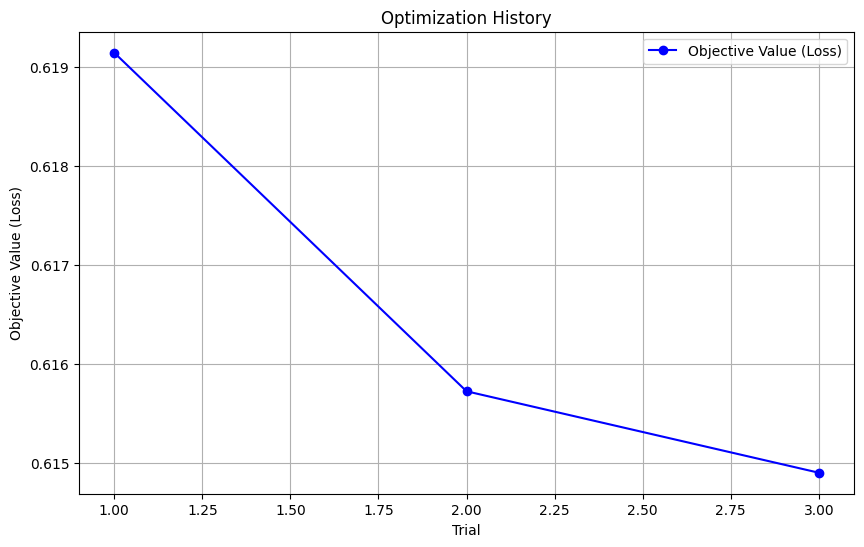

In [30]:
history = [trial.value for trial in study.trials]  # List of objective values (loss in your case)

# Plot the optimization history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history) + 1), history, marker='o', color='b', label='Objective Value (Loss)')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.title('Optimization History')
plt.grid(True)
plt.legend()
plt.show()

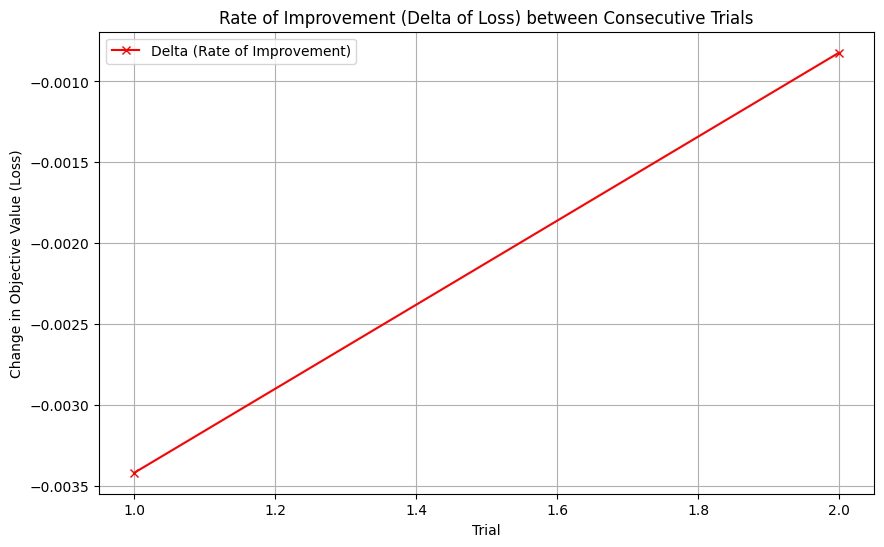

In [31]:
# Calculate the delta between consecutive trials
delta_history = np.diff(history)

# Plotting the rate of improvement (delta of objective values)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(delta_history) + 1), delta_history, marker='x', color='r', label='Delta (Rate of Improvement)')
plt.xlabel('Trial')
plt.ylabel('Change in Objective Value (Loss)')
plt.title('Rate of Improvement (Delta of Loss) between Consecutive Trials')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
BEST_LR_EffB0=study.best_params['lr']
EfficientB0 = SmallEfficientNetB0()
EfficientB0.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(EfficientB0.classifier.parameters(),lr=BEST_LR_EffB0)

trained_EffB0,fold_metrics=train_model(EfficientB0,conc_dataset, criterion, optimizer, num_epochs=2, k=3)


Fold 1/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:53<00:00,  1.72batch/s, accuracy=63.8, loss=0.634]


Train Loss: 0.6342, Train Accuracy: 63.76%


Validation Epoch 1/2: 100%|██████████| 200/200 [02:15<00:00,  1.48batch/s, accuracy=65.7, loss=0.615]


Validation Accuracy: 65.70%
Precision: 0.66, Recall: 0.64


Epoch 2/2: 100%|██████████| 400/400 [03:31<00:00,  1.89batch/s, accuracy=66, loss=0.615]  


Train Loss: 0.6150, Train Accuracy: 66.04%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:41<00:00,  1.97batch/s, accuracy=66.5, loss=0.61] 


Validation Accuracy: 66.48%
Precision: 0.67, Recall: 0.66

Fold 2/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:21<00:00,  1.98batch/s, accuracy=66.1, loss=0.614]


Train Loss: 0.6145, Train Accuracy: 66.09%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:57<00:00,  1.70batch/s, accuracy=68.4, loss=0.59] 


Validation Accuracy: 68.41%
Precision: 0.69, Recall: 0.66


Epoch 2/2: 100%|██████████| 400/400 [03:26<00:00,  1.93batch/s, accuracy=67, loss=0.606]  


Train Loss: 0.6058, Train Accuracy: 66.98%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:42<00:00,  1.94batch/s, accuracy=68.5, loss=0.587]


Validation Accuracy: 68.52%
Precision: 0.68, Recall: 0.70

Fold 3/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:23<00:00,  1.96batch/s, accuracy=66.9, loss=0.605]


Train Loss: 0.6053, Train Accuracy: 66.93%


Validation Epoch 1/2:  32%|███▏      | 64/200 [00:36<01:17,  1.77batch/s, accuracy=71, loss=0.549]  

In [ ]:
test_preds_EffB0, test_labels_EffB0= test_model(trained_EffB0, test_loader)
# Save the model state_dict (recommended approach)
torch.save(trained_EffB0.state_dict(), "EffB0_trained.pth")
print("Model saved successfully asEffB0_trained.pth")

In [ ]:
print(fold_metrics)

plot_fold_metrics(
    train_losses=fold_metrics["train_losses"],
    valid_losses=fold_metrics["valid_losses"],
    train_accuracies=fold_metrics["train_accuracies"],
    valid_accuracies=fold_metrics["valid_accuracies"],
    precisions=fold_metrics["precisions"],
    recalls=fold_metrics["recalls"],
    best_accuracies=fold_metrics["best_accuracy"]
)

# FineTuning EfficientB0

In [ ]:
layers(SmallEfffi)